In [1]:
import numpy as np
import pandas as pd
import easydatascience as eds

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import r2_score, accuracy_score

vanilla_data = pd.read_csv('vanilla_data.csv')
diff_team_data = pd.read_csv('diff_team_data.csv')
diff_data = pd.read_csv('diff_data.csv')
compact_data = pd.read_csv('compact_data.csv')
compact_diff_data = pd.read_csv('compact_diff_data.csv')
bool_team_data = pd.read_csv('bool_team_data.csv')

data = {'vanilla': vanilla_data,
        'diff_team': diff_team_data,
        'diff': diff_data,
        'compact': compact_data,
        'compact_diff': compact_diff_data,
        'bool': bool_team_data}

Using TensorFlow backend.
C:\Users\vucin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vucin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vucin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vucin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Boolean Data
The first dataset I wanted to examine is with only boolean values. Since it is very simple, it has a lot of use cases:
- It doesn't require much computational power so it can be used on any machine.
- Since the data is simple, the model can't be too complicated either (easy to understand).
- Can be good for some simple early predictions.
<br><br>
&emsp;Of course, everything that I mentioned above (as I will do with every dataset that I am going to examine) is prone to change and should not be held true until proven otherwise.

In [2]:
X_train, X_cv, y_train, y_cv = train_test_split(data['bool'].iloc[:, 1:],
                                     data['bool']['Blue_Won'], test_size=0.1)
lr = LogisticRegression()
lr.fit(X_train, y_train)

print('Cross Validation Accuracy:', round(accuracy_score(y_cv, lr.predict(X_cv)), 4))

Cross Validation Accuracy: 0.9798


&emsp;My best guess is that the model is already saturated by similar features with a high correlation. Remember, our goal is not to predict the winner with the data of the game when the game has already been finished, but we want to see the probabilities during the game. So lets first simplify the model and then run an experiment/simulation.

In [3]:
bool1 = data['bool'].iloc[:, :12]
X1_train, X1_test, y1_train, y1_test = train_test_split(bool1.iloc[:, 1:],
                                         bool1['Blue_Won'], test_size=0.1)
lr = LogisticRegression()
lr.fit(X1_train, y1_train)

print('New data accuracy:', round(accuracy_score(y1_test, lr.predict(X1_test)), 4))

sample_data = pd.DataFrame(0.5, index=range(1), columns=bool1.columns[1:])

def print_sample():
    print('\nSample Data:')
    display(sample_data)
    
print_sample()

def proba_byclass():
    print('---------------------\nProbability by class:')
    for class_, proba in zip(lr.classes_, lr.predict_proba(sample_data)[0]):
        print(str(class_)+':', round(proba, 4))
    print('---------------------')
        
proba_byclass()

New data accuracy: 0.9497

Sample Data:


,Blue_FirstBlood,Blue_FirstTower,Blue_FirstInhib,Blue_FirstBaron,Blue_FirstDragon,Blue_FirstHerald,Purp_FirstInhib,Purp_FirstBaron,Purp_FirstHerald,Blue_KDA,Blue_VisionScore
0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


---------------------
Probability by class:
0: 0.5213
1: 0.4787
---------------------


&emsp;It is expected to see the default results as these since the purple time is slightly favored. Let's see how is this going to play out, __The Blue team gets the First Blood__.

In [4]:
sample_data.loc[0, 'Blue_KDA'] = 1
sample_data.loc[0, 'Blue_FirstBlood'] = 1

print_sample()
proba_byclass()


Sample Data:


,Blue_FirstBlood,Blue_FirstTower,Blue_FirstInhib,Blue_FirstBaron,Blue_FirstDragon,Blue_FirstHerald,Purp_FirstInhib,Purp_FirstBaron,Purp_FirstHerald,Blue_KDA,Blue_VisionScore
0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,0.5


---------------------
Probability by class:
0: 0.108
1: 0.892
---------------------


&emsp;This looks a bit oversaturated. The problem here is probably the KDA ratio since the model has been trained on the data from finished games and KDA biases the prediction heavily. We should have that in mind continuing from now on but for now, let's just train the same model but now only without that feature. We can also see that here:

In [5]:
print('---------------------\nLog. Reg. Coefficients:\n')
for ftr, coef in zip(sample_data.columns, lr.coef_[0]):
    print(ftr+':', np.round(coef, 4))
print('---------------------')

---------------------
Log. Reg. Coefficients:

Blue_FirstBlood: -0.0954
Blue_FirstTower: 0.5988
Blue_FirstInhib: 1.6776
Blue_FirstBaron: 0.4642
Blue_FirstDragon: 0.5691
Blue_FirstHerald: -0.0783
Purp_FirstInhib: -1.377
Purp_FirstBaron: -0.7607
Purp_FirstHerald: -0.1586
Blue_KDA: 4.4892
Blue_VisionScore: 0.3464
---------------------


In [6]:
# No KDA
bool2 = data['bool'].iloc[:, :12].drop('Blue_KDA', axis=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(bool2.iloc[:, 1:],
                                         bool1['Blue_Won'], test_size=0.1)
lr.fit(X2_train, y2_train)
print('Accuracy:', round(accuracy_score(y2_test, lr.predict(X2_test)), 4), '\n')

sample_data = pd.DataFrame(0.5, index=range(1), columns=bool2.columns[1:])

proba_byclass()

sample_data.loc[0, 'Blue_FirstBlood'] = 1

print_sample()
proba_byclass()

Accuracy: 0.9024 

---------------------
Probability by class:
0: 0.5325
1: 0.4675
---------------------

Sample Data:


,Blue_FirstBlood,Blue_FirstTower,Blue_FirstInhib,Blue_FirstBaron,Blue_FirstDragon,Blue_FirstHerald,Purp_FirstInhib,Purp_FirstBaron,Purp_FirstHerald,Blue_VisionScore
0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


---------------------
Probability by class:
0: 0.4973
1: 0.5027
---------------------


&emsp;Well, that looks much better! Even though the initial probability of the Blue team winning got a bit lower and I can't seem to be able to explain that right now, it has something to do with the KDA obviously but we are going to leave it for now.
<br><br>
&emsp;On the other side, if you've been paying attention, you might've noticed that Blue_FirstBlood (Blue_FirstHerald is also not very shiny) has a negative coefficient in the Logistic Regression model for some reason. I am not going to explore that into detail so let's just say for now that the model might not be right for the job or that the data doesn't contain enough information. 
<br><br>
&emsp;With that said, __The Purple team uses its jungle vision pressure to take the first dragon but they are quickly countered by the Blue team taking the First Tower. The Blue team takes the First Herald also and they make even more pressure even though the Purple team has more map control through Vision. Blue team snowballs fast taking the first Inhibitor and eventually the First Baron too. By now they have naturally taken over the Vision and they end the game rather fast, by the 25-minute mark. GG!__

In [7]:
sample_data.loc[0, 'Blue_FirstDragon'] = 0
print('First Dragon taken by Purple.')
proba_byclass()

sample_data.loc[0, 'Blue_FirstTower'] = 1
print('\nFirst Tower taken by Blue.')
proba_byclass()

sample_data.loc[0, 'Blue_FirstHerald'] = 1
sample_data.loc[0, 'Purp_FirstHerald'] = 0
sample_data.loc[0, 'Blue_VisionScore'] = 0
print('\nFirst Herald taken by Blue.')
print('Purple controlls the Vision.')
proba_byclass()
print_sample()

sample_data.loc[0, 'Blue_FirstInhib'] = 1
sample_data.loc[0, 'Purp_FirstInhib'] = 0
print('\nFirst Inhib taken by Blue.')
proba_byclass()

sample_data.loc[0, 'Blue_FirstBaron'] = 1
sample_data.loc[0, 'Purp_FirstBaron'] = 0
sample_data.loc[0, 'Blue_VisionScore'] = 1
print('\nFirst Baron taken by Blue.')
print('Blue controlls the Vision.')
proba_byclass()
print_sample()

First Dragon taken by Purple.
---------------------
Probability by class:
0: 0.5863
1: 0.4137
---------------------

First Tower taken by Blue.
---------------------
Probability by class:
0: 0.4763
1: 0.5237
---------------------

First Herald taken by Blue.
Purple controlls the Vision.
---------------------
Probability by class:
0: 0.6061
1: 0.3939
---------------------

Sample Data:


,Blue_FirstBlood,Blue_FirstTower,Blue_FirstInhib,Blue_FirstBaron,Blue_FirstDragon,Blue_FirstHerald,Purp_FirstInhib,Purp_FirstBaron,Purp_FirstHerald,Blue_VisionScore
0,1.0,1.0,0.5,0.5,0.0,1.0,0.5,0.5,0.0,0.0



First Inhib taken by Blue.
---------------------
Probability by class:
0: 0.1831
1: 0.8169
---------------------

First Baron taken by Blue.
Blue controlls the Vision.
---------------------
Probability by class:
0: 0.0272
1: 0.9728
---------------------

Sample Data:


,Blue_FirstBlood,Blue_FirstTower,Blue_FirstInhib,Blue_FirstBaron,Blue_FirstDragon,Blue_FirstHerald,Purp_FirstInhib,Purp_FirstBaron,Purp_FirstHerald,Blue_VisionScore
0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


&emsp;The other binarized numeric value, Vision, has also taken its toll by having too much weight put on it. It is not the same if a team leads by 0.1 KDA vs, 5 KDA, the same goes for the Vision, we can't reduce it to just that. Besides that, the Bool Data gave us a good overview of how could the probabilities move during the game.
<br><br>
&emsp;Remember that even though we are training the model on discrete binary variables, our final goal is still to guess a probability __during__ the game and we have no way of evaluating that. So the model's performance during the final testing is going to be purely subjective and we can't do much about it but take care of training on the hard values and not to make the mistakes as it could be seen with the binarized KDA and Vision.

## Vanilla Data

In [8]:
# Dropping the roles and getting a new df
data['vanilla'] = data['vanilla'][[i for i in data['vanilla'] if 'Role' not in i]]

X_train, X_test, y_train, y_test = train_test_split(data['vanilla'].iloc[:, 1:],
                                     data['vanilla']['Blue_Won'], test_size=0.05)

X_train, X_cv, y_train, y_cv = train_test_split(data['vanilla'].iloc[:, 1:],
                                     data['vanilla']['Blue_Won'], test_size=0.2)

In [9]:
xgb = XGBClassifier(n_estimators=50, max_depth=X_train.shape[1], n_jobs=-1)

xgb.fit(X_train, y_train)
print('r2 score:', r2_score(y_cv, xgb.predict(X_cv)))

r2 score: 0.9494527721288838


In [10]:
def get_importances(cols, rf, threshold=0.002):
    print('---------------------\nImportant features\n---------------------\n')
    important = []

    for feature, importance in zip(cols, [round(i, 6) for i in rf.feature_importances_]):
        if importance > threshold:
            print(feature, importance)
            important.append(feature)
            
    return important

important = get_importances(X_train.columns, xgb)
        
imp_df_train, imp_df_cv = X_train[important], X_cv[important]

xgb_imp = XGBClassifier(n_estimators=50, max_depth=imp_df_train.shape[1], n_jobs=-1)
xgb_imp.fit(imp_df_train, y_train)
print('\nr2 score, only important features:', r2_score(y_cv, xgb_imp.predict(imp_df_cv)))

---------------------
Important features
---------------------

Blue_FirstInhib 0.017061
Blue_KillsTower 0.06262
Blue_KillsInhib 0.031262
Blue_KillsBaron 0.002677
Blue_KillsDragon 0.00216
Purp_FirstBaron 0.004392
Purp_FirstHerald 0.002182
Purp_KillsTower 0.047521
Purp_KillsInhib 0.052228
Purp_KillsBaron 0.003899
player1_LrgstKillSpree 0.002055
player1_KillSprees 0.002369
player3_TtlGold 0.002343
player4_KDAratio 0.002424
player4_LrgstTimeLiving 0.002016
player6_KillSprees 0.002545
player7_KillSprees 0.002875
player8_TtlGold 0.002203
player9_LrgstKillSpree 0.002338
player10_TtlDmgChmp 0.002013
Blue_KDAratio 0.445634
Blue_KillSprees 0.002532
Blue_LrgstTimeLiving 0.002496
Blue_TtlGold 0.002589
Purp_KDAratio 0.140699
Purp_LrgstMultiKill 0.002791
Purp_TtlGold 0.003018

r2 score, only important features: 0.9508439802354283


In [11]:
not_imp_train, not_imp_cv = X_train[[i for i in X_train.columns if i not in important]], X_cv[[i for i in X_cv.columns if i not in important]]
    
xgb_imp = XGBClassifier(n_estimators=50, max_depth=imp_df_train.shape[1], n_jobs=-1)
xgb_imp.fit(not_imp_train, y_train)
print('r2 score, not important features:', r2_score(y_cv, xgb_imp.predict(not_imp_cv)))

r2 score, not important features: 0.8687627019493038


In [12]:
print('---------------------\nAre leftover features important?\n---------------------\n')

for feature, importance in zip(not_imp_train.columns, [round(i, 6) for i in xgb_imp.feature_importances_]):
    if importance > 0.005:
        print(feature, importance)

---------------------
Are leftover features important?
---------------------

Blue_FirstBaron 0.005771
Purp_FirstInhib 0.708678
Purp_KillsDragon 0.006138
player1_KDAratio 0.005317
player2_KDAratio 0.005079
player3_KDAratio 0.007132
player5_KDAratio 0.009173
player7_KDAratio 0.010891
player9_KDAratio 0.005626
player10_KDAratio 0.005391
Blue_LrgstKillSpree 0.115219
Blue_TtlDmg 0.007152


In [13]:
important = ['Blue_FirstTower', 'Blue_FirstInhib', 'Blue_FirstDragon', 
             'Blue_FirstHerald', 'Blue_KillsTower', 'Blue_KillsInhib', 
             'Blue_KillsBaron', 'Purp_FirstInhib', 'Purp_FirstHerald', 
             'Purp_KillsTower', 'Purp_KillsInhib', 'Purp_KillsBaron', 
             'Blue_KDAratio', 'Blue_TtlGold', 'Purp_KDAratio', 'Purp_TtlGold']

X_train, X_cv, X_test = X_train[important], X_cv[important], X_test[important]

train_idx = X_train.index
cv_idx = X_cv.index
test_idx = X_test.index

&emsp;There are some features like Blue_LrgstTimeLiving or some player features that probably wound up above the 0.002 threshold because of some random (most likely statistically insignificant) outcome. That is why I handpicked the features.

## Difference Team Data

In [14]:
X1, y1 = data['diff_team'].iloc[:, 10:], data['diff_team']['Blue_Won']

X1_train, y1_train = X1.iloc[train_idx], y1[train_idx]
X1_cv, y1_cv = X1.iloc[cv_idx], y1[cv_idx]
X1_test, y1_test = X1.iloc[test_idx], y1[test_idx]

In [15]:
xgb = XGBClassifier(n_estimators=50, max_depth=X1_train.shape[1], n_jobs=-1)

xgb.fit(X1_train, y1_train)
print('r2 score:', r2_score(y1_cv, xgb.predict(X1_cv)))

r2 score: 0.9517714523064579


In [16]:
important = get_importances(X1_train.columns, xgb, threshold=0.01)

---------------------
Important features
---------------------

KillsTower 0.015896
KillsInhib 0.051395
TtlGold 0.876719


In [17]:
# Dropping features, renaming and merging
X1_train, X1_cv, X1_test = X1_train[important], X1_cv[important], X1_test[important]

X1_train.columns = ['Diff_'+i for i in important]
X1_cv.columns = ['Diff_'+i for i in important]
X1_test.columns = ['Diff_'+i for i in important]

X_train = pd.concat([X_train, X1_train], axis=1)
X_cv = pd.concat([X_cv, X1_cv], axis=1)
X_test = pd.concat([X_test, X1_test], axis=1)

## Compact Data

In [18]:
X1, y1 = data['compact'].iloc[:, 1:], data['compact']['Blue_Won']
X1 = X1[[i for i in X1 if 'Role' not in i]]

X1_train, y1_train = X1.iloc[train_idx], y1[train_idx]
X1_cv, y1_cv = X1.iloc[cv_idx], y1[cv_idx]
X1_test, y1_test = X1.iloc[test_idx], y1[test_idx]

xgb = XGBClassifier(n_estimators=50, max_depth=X1_train.shape[1], n_jobs=-1)

xgb.fit(X1_train, y1_train)
print('r2 score, compact:', r2_score(y1_cv, xgb.predict(X1_cv)), '\n')

important = get_importances(X1_train.columns, xgb, threshold=0.005)

xgb.fit(X1_train[important], y1_train)
print('\nr2 score, important compact:',r2_score(y1_cv, xgb.predict(X1_cv[important])))

r2 score, compact: 0.9452791478092504 

---------------------
Important features
---------------------

Blue_FirstInhib 0.021692
Blue_KillsTower 0.071738
Blue_KillsInhib 0.044275
Purp_KillsTower 0.049151
Purp_KillsInhib 0.06694
Blue_KDAratio 0.455425
Purp_KDAratio 0.195509

r2 score, important compact: 0.943424203667191


&emsp;It seems like I shouldn't have made the assumptions about the data to make a compact one, feature importance on the vanilla was enough.

## Merged Data

In [19]:
# Merged score
xgb = XGBClassifier(n_estimators=50, max_depth=X_train.shape[1], n_jobs=-1)

xgb.fit(X_train, y_train)
print('r2 score, merged:', r2_score(y_cv, xgb.predict(X_cv)))

r2 score, merged: 0.9531626604130023


In [20]:
# SpearmanR correlation between the forest features
import scipy
spearman = np.round(scipy.stats.spearmanr(X_train).correlation, 4)

for idx, col in enumerate(X_train.columns):
    curr_corr = spearman[idx].tolist()
    print('\n---------------------\n', col, '\n---------------------\n')
    
    for corr in curr_corr:
        curr_idx = curr_corr.index(corr)

        if abs(corr)>0.8 and idx != curr_idx:
            print(X_train.columns[curr_idx], corr)


---------------------
 Blue_FirstTower 
---------------------


---------------------
 Blue_FirstInhib 
---------------------

Blue_KillsTower 0.8042
Blue_KillsInhib 0.8902
Diff_KillsInhib 0.8313

---------------------
 Blue_FirstDragon 
---------------------


---------------------
 Blue_FirstHerald 
---------------------


---------------------
 Blue_KillsTower 
---------------------

Blue_FirstInhib 0.8042
Blue_KillsInhib 0.8826
Diff_KillsTower 0.8887
Diff_KillsInhib 0.8017
Diff_TtlGold 0.8142

---------------------
 Blue_KillsInhib 
---------------------

Blue_FirstInhib 0.8902
Blue_KillsTower 0.8826
Diff_KillsTower 0.8066
Diff_KillsInhib 0.8654

---------------------
 Blue_KillsBaron 
---------------------


---------------------
 Purp_FirstInhib 
---------------------

Purp_KillsInhib 0.8803
Diff_KillsInhib -0.835

---------------------
 Purp_FirstHerald 
---------------------


---------------------
 Purp_KillsTower 
---------------------

Purp_KillsInhib 0.8848
Diff_KillsTower

In [21]:
# Do we want to drop any features to reduce the feature space
for feature in X_train.columns:
    xgb.fit(X_train.drop(feature, axis=1), y_train)
    print(f'r2 score, merged, without {feature}:', 
          round(r2_score(y_cv, xgb.predict(X_cv.drop(feature, axis=1))), 4))

r2 score, merged, without Blue_FirstTower: 0.9541
r2 score, merged, without Blue_FirstInhib: 0.9536
r2 score, merged, without Blue_FirstDragon: 0.9546
r2 score, merged, without Blue_FirstHerald: 0.9508
r2 score, merged, without Blue_KillsTower: 0.955
r2 score, merged, without Blue_KillsInhib: 0.9499
r2 score, merged, without Blue_KillsBaron: 0.9541
r2 score, merged, without Purp_FirstInhib: 0.9527
r2 score, merged, without Purp_FirstHerald: 0.9546
r2 score, merged, without Purp_KillsTower: 0.9518
r2 score, merged, without Purp_KillsInhib: 0.9513
r2 score, merged, without Purp_KillsBaron: 0.9541
r2 score, merged, without Blue_KDAratio: 0.9573
r2 score, merged, without Blue_TtlGold: 0.9513
r2 score, merged, without Purp_KDAratio: 0.9541
r2 score, merged, without Purp_TtlGold: 0.9546
r2 score, merged, without Diff_KillsTower: 0.955
r2 score, merged, without Diff_KillsInhib: 0.9527
r2 score, merged, without Diff_TtlGold: 0.9508


## Outliers

In [22]:
eds.look(X_train)

,Types,Counts,Distincts,Nulls,Missing ratio (%),Uniques,Skewness
Blue_FirstTower,int64,34509,2,0,0.0,"[[0.0, 1.0]]",-0.019185
Blue_FirstInhib,int64,34509,2,0,0.0,"[[0.0, 1.0]]",0.289593
Blue_FirstDragon,int64,34509,2,0,0.0,"[[1.0, 0.0]]",0.045161
Blue_FirstHerald,int64,34509,2,0,0.0,"[[0.0, 1.0]]",0.157846
Blue_KillsTower,int64,34509,12,0,0.0,"[[4.0, 8.0, 3.0, 10.0, 7.0, 9.0, 0.0, 1.0, 11....",0.062150
Blue_KillsInhib,int64,34509,5,0,0.0,"[[0.0, 2.0, 3.0, 1.0, 4.0]]",1.128625
Blue_KillsBaron,int64,34509,3,0,0.0,"[[0.0, 1.0, 2.0]]",1.215781
Purp_FirstInhib,int64,34509,2,0,0.0,"[[1.0, 0.0]]",0.276576
Purp_FirstHerald,int64,34509,2,0,0.0,"[[1.0, 0.0]]",0.314894
Purp_KillsTower,int64,34509,12,0,0.0,"[[5.0, 2.0, 10.0, 3.0, 6.0, 11.0, 0.0, 1.0, 8....",0.024500


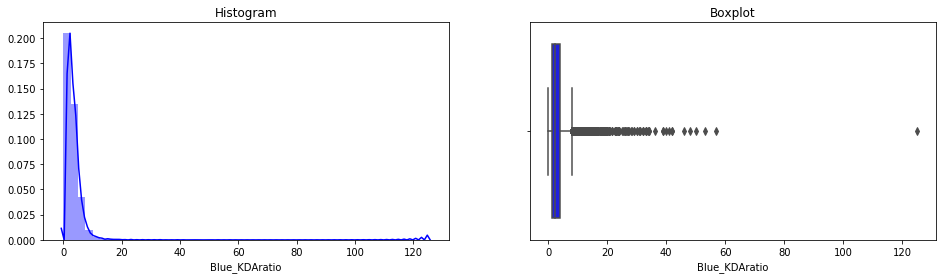


Skew:  6.8157
Mean:  3.0369
Standard Deviation:  2.6138


In [23]:
eds.plot_spread(X_train['Blue_KDAratio'])

In [24]:
display(X_train.loc[X_train['Blue_KDAratio']>100])
print('Blue Won:', y_train.iloc[4705])

,Blue_FirstTower,Blue_FirstInhib,Blue_FirstDragon,Blue_FirstHerald,Blue_KillsTower,Blue_KillsInhib,Blue_KillsBaron,Purp_FirstInhib,Purp_FirstHerald,Purp_KillsTower,Purp_KillsInhib,Purp_KillsBaron,Blue_KDAratio,Blue_TtlGold,Purp_KDAratio,Purp_TtlGold,Diff_KillsTower,Diff_KillsInhib,Diff_TtlGold
4705,1,1,0,0,9,2,0,0,0,0,0,0,125.0,45171,0.03125,13232,9,2,31939


Blue Won: 0


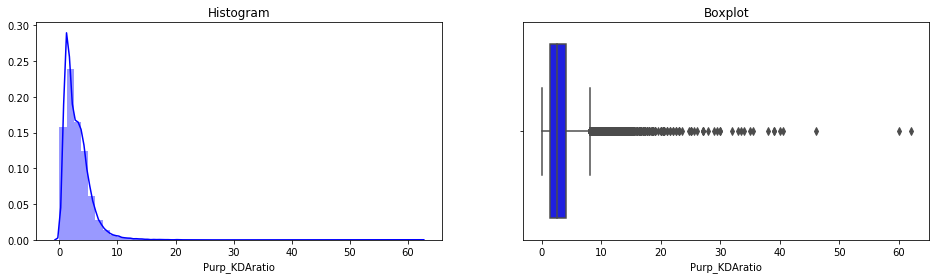


Skew:  3.8394
Mean:  3.0612
Standard Deviation:  2.4081


In [25]:
eds.plot_spread(X_train['Purp_KDAratio'])

In [26]:
display(X_train.loc[X_train['Purp_KDAratio']>58])
for i in y_train.iloc[[16310, 19581]]:
    print('Blue Won:', i)

,Blue_FirstTower,Blue_FirstInhib,Blue_FirstDragon,Blue_FirstHerald,Blue_KillsTower,Blue_KillsInhib,Blue_KillsBaron,Purp_FirstInhib,Purp_FirstHerald,Purp_KillsTower,Purp_KillsInhib,Purp_KillsBaron,Blue_KDAratio,Blue_TtlGold,Purp_KDAratio,Purp_TtlGold,Diff_KillsTower,Diff_KillsInhib,Diff_TtlGold
19581,0,0,0,0,0,0,0,1,1,8,1,0,0.000000,20582,60.0,37122,-8,-1,-16540
16310,0,0,1,0,0,0,0,1,1,8,1,1,0.136364,30974,62.0,47139,-8,-1,-16165


Blue Won: 0
Blue Won: 0


&emsp;Since we are not using a linear model, we shouldn't be too much concerned with the outliers but the one in the Blue_KDAratio has caught my attention. Even though it is the highest KDA ratio for a team in the whole training set, the team (Blue) hasn't won that match.

In [27]:
train_lght, cv_lght, test_lght = X_train.shape[0], X_cv.shape[0], X_test.shape[0]

X_train = X_train.loc[X_train['Blue_KDAratio']<80]
X_train = X_train.loc[X_train['Purp_KDAratio']<80]
y_train = y_train.drop([i for i in y_train.index if i not in X_train.index])

X_cv = X_cv.loc[X_cv['Blue_KDAratio']<80]
X_cv = X_cv.loc[X_cv['Purp_KDAratio']<80]
y_cv = y_cv.drop([i for i in y_cv.index if i not in X_cv.index])

X_test = X_test.loc[X_test['Blue_KDAratio']<80]
X_test = X_test.loc[X_test['Purp_KDAratio']<80]
y_test = y_test.drop([i for i in y_test.index if i not in X_test.index])

print('Train values trimmed: ', train_lght - X_train.shape[0])
print('CV values trimmed: ', cv_lght - X_cv.shape[0])
print('Test values trimmed: ', test_lght - X_test.shape[0])

Train values trimmed:  1
CV values trimmed:  0
Test values trimmed:  0


&emsp;*NOTE*: This is in one game that happened to be sampled in the train set when I made this part of the notebook and I forgot that I am going to distort it by rerunning it. Feel free to change the code so it displays the value in the respective dataset where it is located.

## Models

In [28]:
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()
params = [
    {'n_estimators': [10, 20, 40, 100, 200, 400], 'min_samples_leaf': [1, 3, 5],
     'colsample_bytree': [0.5, 0.7, 0.9, 1], 'n_jobs': [-1]}
]

grid = GridSearchCV(xgb, params, scoring=['r2', 'accuracy'], return_train_score=True,
                    cv=3, refit='r2')
grid.fit(X_train, y_train)

# Grid 2 hyperparams: max_depth, jeff heathon

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'colsample_bytree': [0.5, 0.7, 0.9, 1],
                          'min_samples_leaf': [1, 3, 5],
                          'n_estimators': [10, 20, 40,

In [29]:
grid.best_params_

{'colsample_bytree': 0.5,
 'min_samples_leaf': 1,
 'n_estimators': 200,
 'n_jobs': -1}

In [30]:
params = [
    {'n_estimators': [100], 'min_samples_leaf': [1], 'max_depth':[5, 10, 15, 19],
     'colsample_bytree': [0.4, 0.5, 0.6], 'n_jobs': [-1]}
]

grid = GridSearchCV(xgb, params, scoring=['r2', 'accuracy'], return_train_score=True,
                    cv=3, refit='r2')
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'colsample_bytree': [0.4, 0.5, 0.6],
                          'max_depth': [5, 10, 15, 19], 'min_samples_leaf': [1],
                          'n_esti

In [31]:
grid.best_params_

{'colsample_bytree': 0.5,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'n_estimators': 100,
 'n_jobs': -1}

In [32]:
xgb = XGBClassifier(n_estimators=100, max_depth=5, colsample_bytree=0.4,
                    min_samples_leaf=1, n_jobs=-1)
xgb.fit(X_train, y_train)

lr = LogisticRegression()
lr.fit(X_train, y_train)

def get_scores(model, X, y):
    r2 = round(r2_score(y, model.predict(X)), 6)
    acc = round(accuracy_score(y, model.predict(X)), 6)
    print([r2, acc])

print('XGB test:')
get_scores(xgb, X_test, y_test)

print('\nLR test:')
get_scores(lr, X_test, y_test)

print('\n(r2 and accuracy)')

XGB test:
[0.977718, 0.994437]

LR test:
[0.936869, 0.984237]

(r2 and accuracy)


In [38]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_cv_scaled, X_test_scaled = ss.transform(X_cv), ss.transform(X_test)

lrs = LogisticRegression()
lrs.fit(X_train_scaled, y_train)

print('LR scaled cv:')
get_scores(lrs, X_cv_scaled, y_cv)

print('\nLR scaled test:')
get_scores(lrs, X_test_scaled, y_test)

LR scaled cv:
[0.943888, 0.985976]

LR scaled test:
[0.95358, 0.98841]


&emsp;We can scale the data for a slight accuracy boost or we can leave it as it is if we want to preserve the interpretability.

## Sample
&emsp;The real test now begins. We are going to look at how our features and predictions behave like in a real game. The reason I kept logistic regression is that its initial 50%/50% win probabilities (as you would expect) held true and the pre-testing I did on the random forest seemed to bias for some reason.

In [33]:
def class_probs(ftrs, model):
    for team, proba in zip(model.classes_, model.predict_proba(ftrs)[0]):
        print(str(team)+':', round(proba, 4))
        
game_start = pd.DataFrame(np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2500, 
                                     0, 2500, 0, 0, 0]]), columns=X_train.columns)
print('Features at the start of a game:')
display(game_start)

print('---------------------\nProbabilities at game start:\n---------------------')
print('XGB:')
class_probs(game_start.iloc[:1], xgb)
print('\nLR:')
class_probs(game_start.iloc[:1], lr)

Features at the start of a game:


,Blue_FirstTower,Blue_FirstInhib,Blue_FirstDragon,Blue_FirstHerald,Blue_KillsTower,Blue_KillsInhib,Blue_KillsBaron,Purp_FirstInhib,Purp_FirstHerald,Purp_KillsTower,Purp_KillsInhib,Purp_KillsBaron,Blue_KDAratio,Blue_TtlGold,Purp_KDAratio,Purp_TtlGold,Diff_KillsTower,Diff_KillsInhib,Diff_TtlGold
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2500,0,2500,0,0,0


---------------------
Probabilities at game start:
---------------------
XGB:
0: 0.1371
1: 0.8629

LR:
0: 0.4991
1: 0.5009


In [34]:
sample_game = pd.read_csv('sample_game.csv')

sample_game['XGB_1'] = pd.DataFrame(xgb.predict_proba(sample_game.iloc[:, 1:20]))[1]
sample_game['XGB_0'] = pd.DataFrame(xgb.predict_proba(sample_game.iloc[:, 1:20]))[0]
sample_game['LR_1'] = pd.DataFrame(lr.predict_proba(sample_game.iloc[:, 1:20]))[1]
sample_game['LR_0'] = pd.DataFrame(lr.predict_proba(sample_game.iloc[:, 1:20]))[0]

In [35]:
sample_game

,Minute,Blue_FirstTower,Blue_FirstInhib,Blue_FirstDragon,Blue_FirstHerald,Blue_KillsTower,Blue_KillsInhib,Blue_KillsBaron,Purp_FirstInhib,Purp_FirstHerald,...,Blue_TtlGold,Purp_KDAratio,Purp_TtlGold,Diff_KillsTower,Diff_KillsInhib,Diff_TtlGold,XGB_1,XGB_0,LR_1,LR_0
0,1,0.5,0,0.5,0,0,0,0,0,0,...,2500,0.000000,2500,0,0,0,0.795397,0.204603,0.499298,0.500702
1,2,0.5,0,0.5,0,0,0,0,0,0,...,3000,0.000000,3000,0,0,0,0.795397,0.204603,0.499487,0.500513
2,3,0.5,0,0.5,0,0,0,0,0,0,...,4600,0.000000,4500,0,0,100,0.795397,0.204603,0.515526,0.484474
3,4,0.5,0,0.5,0,0,0,0,0,0,...,6200,2.000000,6300,0,0,-100,0.557704,0.442296,0.485513,0.514487
4,5,0.5,0,0.5,0,0,0,0,0,0,...,7400,2.000000,7600,0,0,-200,0.557704,0.442296,0.470558,0.529442
5,6,0.5,0,0.5,0,0,0,0,0,0,...,9000,2.000000,9300,0,0,-300,0.557704,0.442296,0.455805,0.544195
6,7,0.5,0,0.5,0,0,0,0,0,0,...,10100,2.000000,10900,0,0,-800,0.540523,0.459477,0.381223,0.618777
7,8,0.5,0,0.5,0,0,0,0,0,0,...,11500,2.000000,12200,0,0,-700,0.517234,0.482766,0.396401,0.603599
8,9,0.5,0,1.0,0,0,0,0,0,0,...,12900,2.000000,14200,0,0,-1300,0.636030,0.363970,0.312904,0.687096
9,10,0.5,0,1.0,0,0,0,0,0,0,...,13800,3.000000,15800,0,0,-2000,0.050160,0.949840,0.219297,0.780703


&emsp;Even though XGBoost might have better overall scores on the test data, it failed the actual test it is meant to be used for. I could go further to investigate why is that the case but in the end, the feature space has only 19 columns where XGBoost would be an overkill, especially because our objective isn't clearly defined. I also planned to use Logistic regression up to some point in the game and then transition to the XGBoost because it is more accurate but as I said, it is an overkill.
<br><br>
This sample/demo might have not been enough so I did the more detailed one in the next section of the project, accompanied by a video.

In [45]:
import joblib

joblib.dump(lr, 'logistic_regression.pkl')
joblib.dump(lrs, 'scaled_logistic_regression.pkl');